In [31]:
import pandas as pd
from sklearn.model_selection import cross_val_score, KFold, train_test_split, learning_curve
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import make_scorer, mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
import numpy as np

### Read the data and drop less useful columns

In [32]:
non_feature_columns = ['Ticker Symbol', 'Period Ending', 'Sector', 'For Year', 'Next Qtr. Avg. Price', 'Q avg to Q avg Price % Change', 'Y avg to Y avg Price % Change', 'Up or Down Q over Q', 'Up or Down Y over Y', 'Buy, Hold, or Sell']
less_useful_parameters = ["Add'l income/expense items", "Deferred Asset Charges", "Deferred Liability Charges", "Effect of Exchange Rate", "Minority Interest", "Misc. Stocks", "Non-Recurring Items", "Other Assets", "Other Current Assets", "Other Current Liabilities", "Other Equity", "Other Financing Activities", "Other Investing Activities", "Other Liabilities", "Other Operating Activities", "Other Operating Items"]
target_variable = 'Next Qtr. Avg. Price'

# Load the dataset
data = pd.read_csv('../data/merged_data.csv')

# Drop less useful fundamental parameters
data = data.drop(columns=less_useful_parameters)

# Check for NaN values in target variable and handle them
if data[target_variable].isna().sum() > 0:
    data[target_variable].fillna(method='bfill', inplace=True)


### Select the top 30 features using RF feature importance metrics

In [33]:
# Select features and finalise the dataset for RF model

features = data.columns.difference(non_feature_columns)
X = data.drop(columns=non_feature_columns)
y = data[target_variable]

rf_model_fs = RandomForestRegressor(n_estimators=1000, random_state=42)
rf_model_fs.fit(X, y)

feature_importances = rf_model_fs.feature_importances_
importance_df = pd.DataFrame({'Feature': features, 'Importance': feature_importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Select top 30 features
selected_features = importance_df['Feature'].head(30).to_numpy()
print(f'Selected Features:\n{selected_features}')

final_data = pd.DataFrame()
final_data['Ticker Symbol'] = data['Ticker Symbol']
final_data['Period Ending'] = data['Period Ending']
final_data[selected_features] = data[selected_features]
final_data[target_variable] = data[target_variable].round(2)

final_data.to_csv('../data/rf_data.csv')


Selected Features:
['Total Revenue' 'Treasury Stock' 'Inventory' 'Common Stocks'
 'Changes in Inventories' 'Quick Ratio' 'Total Current Liabilities'
 'Capital Surplus' 'Estimated Shares Outstanding' 'Fixed Assets'
 'Earnings Before Tax' 'Pre-Tax ROE' 'Total Current Assets'
 'Capital Expenditures' 'Gross Margin' 'Total Liabilities & Equity'
 'Cash Ratio' 'Equity Earnings/Loss Unconsolidated Subsidiary'
 'Profit Margin' 'Depreciation' 'Accounts Receivable' 'Investments'
 'Net Income Applicable to Common Shareholders' 'Total Assets'
 'Cost of Revenue' 'Earnings Per Share' 'Intangible Assets' 'Gross Profit'
 'Net Cash Flows-Investing' 'Operating Margin']


### Load the data with the selected features and split it into 'test' and 'train' datasets

In [34]:
# Load the final data
data = pd.read_csv('../data/rf_data.csv')
features = data.columns.difference(non_feature_columns)

# Split data into train and test
def split_data(group, train_size=0.7):
    if len(group) > 1:
        train, test = train_test_split(group, train_size=train_size, shuffle=False)
    else:
        train, test = group, group
    return train, test

# Initialize empty DataFrames for training and testing data
train_data = pd.DataFrame()
test_data = pd.DataFrame()

# Group by 'Ticker Symbol' and split the data
for symbol, group in data.groupby('Ticker Symbol'):
    train_group, test_group = split_data(group)
    train_data = pd.concat([train_data, train_group])
    test_data = pd.concat([test_data, test_group])

# Reset the index of the resulting DataFrames
train_data.reset_index(drop=True, inplace=True)
test_data.reset_index(drop=True, inplace=True)


train_data.to_csv('./outputs/rf_train_data.csv')
test_data.to_csv('./outputs/rf_test_data.csv')

X = data[features]
y = data[target_variable]

X_train = train_data[features]
y_train = train_data[target_variable]

X_test = test_data[features]
y_test = test_data[target_variable]

### Standardize the column values before training the model

In [35]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


### Use cross-validation to train and validate the model

In [36]:
rf_model_cv = RandomForestRegressor(n_estimators=1000, random_state=42)

mse_scorer = make_scorer(mean_squared_error, greater_is_better=False)

kf = KFold(n_splits=10, shuffle=True, random_state=42)

# Cross-validate for MSE
cv_mse_scores = cross_val_score(rf_model_cv, X_scaled, y, cv=kf, scoring=mse_scorer)
cv_mse = -cv_mse_scores.mean()  # Negate the scores because greater_is_better=False for MSE
print(f'Mean Cross-Validated MSE: {cv_mse:.2f}')


Mean Cross-Validated MSE: 2380.99


### Evaluate the MSE produced by the model

In [37]:
rf_model = RandomForestRegressor(n_estimators=1000, random_state=42)

rf_model.fit(X_train_scaled, y_train)
y_pred_test = rf_model.predict(X_test_scaled)

# Testing metrics
mse = mean_squared_error(y_test, y_pred_test)
r2 = r2_score(y_test, y_pred_test)
print(f'MSE: {mse:.2f}')
print(f'R-squared: {r2:.2f}')

MSE: 2207.79
R-squared: 0.75


### Compute and plot Residuals

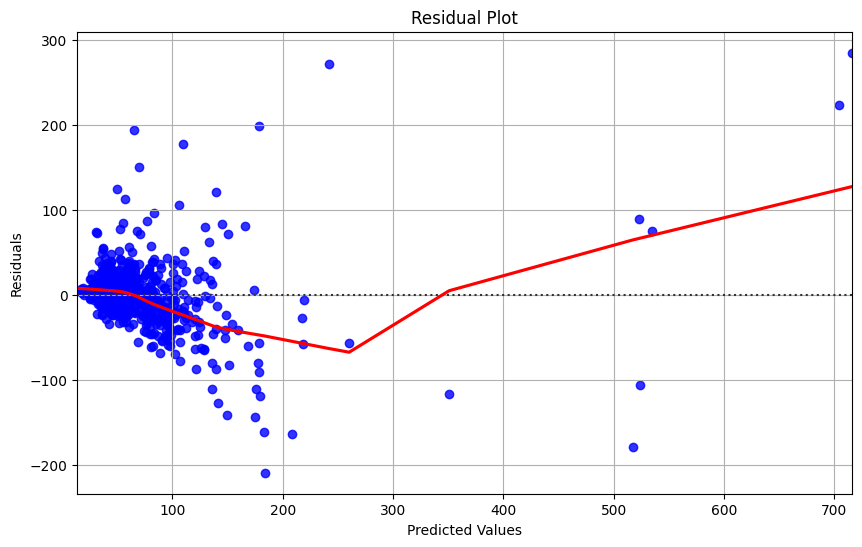

In [38]:
# Calculate residuals
residuals = y_test - y_pred_test

# Plot residuals
plt.figure(figsize=(10, 6))
sns.residplot(x=y_pred_test, y=residuals, lowess=True, color='blue', line_kws={'color': 'red'})
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.grid(True)
plt.show()



### Analyse the model fit using PCA

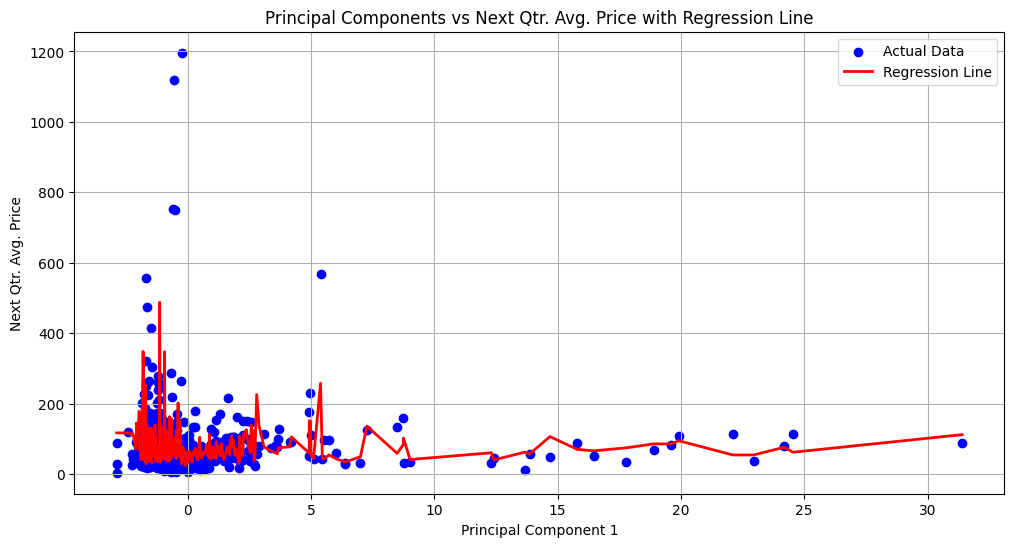

In [39]:
# Using PCA for visualisation purpose

pca = PCA(n_components=2)  # Reduce to 2 principal components
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

rf_model_pca = RandomForestRegressor(n_estimators=1000, random_state=42)
rf_model_pca.fit(X_train_pca, y_train)

y_pred_test = rf_model_pca.predict(X_test_pca)

plt.figure(figsize=(12, 6))

# Scatter plot for actual data points
plt.scatter(X_test_pca[:, 0], y_test, color='blue', label='Actual Data')

# Plot the regression fit line
sorted_indices = np.argsort(X_test_pca[:, 0])
plt.plot(X_test_pca[sorted_indices, 0], y_pred_test[sorted_indices], color='red', linewidth=2, label='Regression Line')

plt.xlabel('Principal Component 1')
plt.ylabel(target_variable)
plt.title('Principal Components vs Next Qtr. Avg. Price with Regression Line')
plt.legend()
plt.grid(True)

# Display plot
plt.show()
